# Proyecto 1: Noticias Falsas en Política

## Etapa 2: Informe

**Grupo 27**

---

**Descripción del Proyecto:**

Este proyecto tiene como objetivo desarrollar una aplicación capaz de detectar noticias falsas dentro del ámbito político colombiano. La Etapa 2 se centra en la implementación de una API robusta utilizando FastAPI, la creación de un pipeline de procesamiento de texto para el análisis de noticias, el entrenamiento de un modelo de clasificación (XGBoost) y la construcción de una interfaz de usuario intuitiva con Streamlit para la interacción del usuario. La aplicación permite tanto la predicción individual de la veracidad de noticias como la capacidad de reentrenar el modelo con nuevos datos, buscando así adaptarse y mejorar su precisión en el contexto específico de la información política en Colombia.

---

**Miembros del Grupo:**

* Juan Manuel Ramírez
* Daniel Esteban Gomez
* Juan Diego Osorio

---

**29 de marzo del 2025**

In [ ]:
!pip install flask xgboost scikit-learn pandas numpy pickle-mixin pyngrok flask-ngrok


# Sección 1

## Preprocesamiento de datos

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  int64 
 2   Titulo       57047 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB
None

Valores nulos por columna:
ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64
FILAS CON VALORES NULOS ELIMINADOS

Número de filas dup

<ipython-input-7-ddb677a23034>:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df, palette='coolwarm')


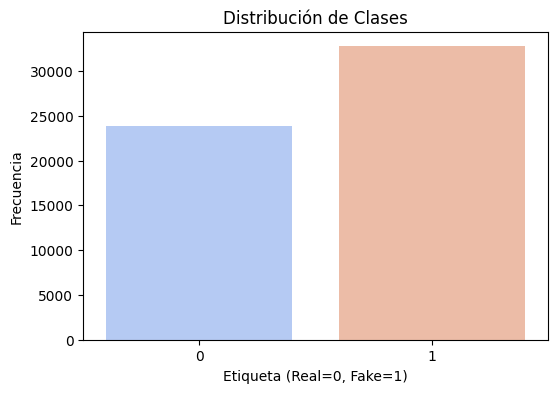


Ejemplo de datos preprocesados:
                                              Titulo  \
0  'The Guardian' va con Sánchez: 'Europa necesit...   
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
4  Puigdemont: 'No sería ninguna tragedia una rep...   

                                         Descripcion  \
0  El diario británico publicó este pasado jueves...   
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  El valencianismo convoca en Castelló su fiesta...   
3  En política, igual que hay que negociar con lo...   
4  En una entrevista en El Punt Avui, el líder de...   

                                     texto_procesado  
0  the guardian ir sánchez europa necesitar apues...  
1  revelar gobierno negocio liberación mirel camb...  
2  ahora nunca joan fuster estatuto valenciano cu...  
3  iglesia alentar yolanda díaz erc eh bildu nego...  
4  puigdemont ser 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy.cli
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Descargar stopwords en español
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('spanish'))

# Cargar modelo de spaCy en español
spacy.cli.download("es_core_news_sm")  # Descarga el modelo si aún no está disponible
nlp = spacy.load("es_core_news_sm")

def preprocess_text(text):
    reemplazos = {
        'Ã¡': 'á', 'Ã©': 'é', 'Ã­': 'í', 'Ã³': 'ó', 'Ãº': 'ú',
        'ÃÁ': 'Á', 'Ã‰': 'É', 'ÃÍ': 'Í', 'Ã“': 'Ó', 'Ãš': 'Ú',
        'Ã±': 'ñ', 'Ã‘': 'Ñ', 'Â¿': '¿', 'Â¡': '¡',
        'â€œ': '“', 'â€': '”', 'â€˜': '‘', 'â€™': '’', 'â€¦': '…',
        'Â«': '«', 'Â»': '»', 'â€”': '—', 'â€“': '–'
    }

    for error, correcto in reemplazos.items():
        text = text.replace(error, correcto)

    """ Tokeniza, elimina stopwords y lematiza el texto. """
    if pd.isna(text):  # Si el texto es NaN, devolver vacío
        return ""

    # Tokenización y lematización con spaCy
    doc = nlp(text.lower())  # Convertir a minúsculas
    tokens = [token.lemma_ for token in doc if token.text.isalpha()]  # Solo palabras (sin números o símbolos)

    # Eliminar stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]



    return " ".join(filtered_tokens)  # Unir palabras en un solo string


def load_and_profile_data(file_path):
    # Cargar el dataset
    df = pd.read_csv(file_path, delimiter=';', encoding='utf-8')

    # Mostrar información general del dataset
    print("Información del DataFrame:")
    print(df.info())

    # Identificar valores nulos
    print("\nValores nulos por columna:")
    print(df.isnull().sum())

    # Eliminar filas con valores nulos en título, descripción o etiqueta
    df.dropna(subset=['Titulo', 'Descripcion', 'Label'], inplace=True)
    print("FILAS CON VALORES NULOS ELIMINADOS")

    # Identificar duplicados
    duplicate_rows = df.duplicated().sum()
    print(f"\nNúmero de filas duplicadas: {duplicate_rows}")

    # Eliminar duplicados
    df.drop_duplicates(inplace=True)
    print("DUPLICADOS ELIMINADOS")

    # Longitud promedio de título y descripción
    df['Titulo_len'] = df['Titulo'].apply(lambda x: len(str(x)))
    df['Descripcion_len'] = df['Descripcion'].apply(lambda x: len(str(x)))
    print("\nLongitud promedio del título:", df['Titulo_len'].mean())
    print("Longitud promedio de la descripción:", df['Descripcion_len'].mean())

    # Verificar formato de fechas
    try:
        df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y', errors='coerce')
        invalid_dates = df['Fecha'].isna().sum()
        print(f"\nNúmero de fechas con formato erróneo: {invalid_dates}")
    except Exception as e:
        print(f"Error al procesar fechas: {e}")

    # Distribución de la variable objetivo (Label)
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Label', data=df, palette='coolwarm')
    plt.title('Distribución de Clases')
    plt.xlabel('Etiqueta (Real=0, Fake=1)')
    plt.ylabel('Frecuencia')
    plt.show()

    # Aplicar preprocesamiento al título y descripción
    df['Titulo_clean'] = df['Titulo'].apply(preprocess_text)
    df['Descripcion_clean'] = df['Descripcion'].apply(preprocess_text)

    # Unir título y descripción preprocesados en una nueva columna
    df['texto_procesado'] = df['Titulo_clean'] + " " + df['Descripcion_clean']

    print("\nEjemplo de datos preprocesados:")
    print(df[['Titulo', 'Descripcion', 'texto_procesado']].head())

    return df

# Ruta al archivo CSV (reemplazar con la ruta correcta)
file_path = 'fake_news_spanish.csv'

df = load_and_profile_data(file_path)

# Vectorización con TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Consideramos las 5000 palabras más relevantes
X_tfidf = vectorizer.fit_transform(df["texto_procesado"])

# Guardar la matriz TF-IDF en un archivo
with open("tfidf_vectorized.pkl", "wb") as f:
    pickle.dump(X_tfidf, f)

# Guardar el vectorizador para futuras predicciones
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Guardar el DataFrame limpio sin la matriz TF-IDF (ya que es muy grande)
df.drop(columns=['Titulo_clean', 'Descripcion_clean', 'texto_procesado'], inplace=True)
df.to_csv("fake_news_spanish_clean.csv", index=False)

print("Preprocesamiento y vectorización completados. Datos guardados.")


## Modelo

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9240
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90      4774
           1       0.90      0.98      0.94      6547

    accuracy                           0.92     11321
   macro avg       0.93      0.91      0.92     11321
weighted avg       0.93      0.92      0.92     11321

Modelo XGBoost guardado exitosamente como 'xgboost_model.pkl'


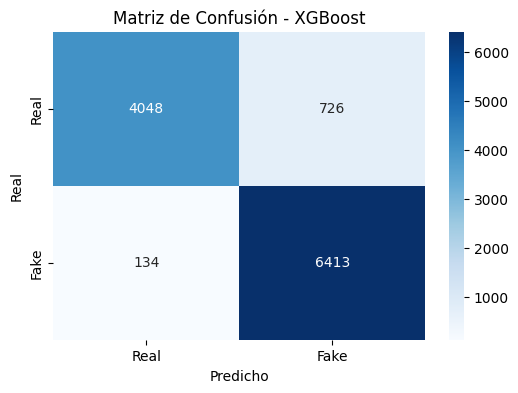

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load cleaned dataset
df = pd.read_csv("fake_news_spanish_clean.csv")

# Load precomputed TF-IDF matrix
with open("tfidf_vectorized.pkl", "rb") as f:
    X_tfidf = pickle.load(f)

# Define target variable
y = df['Label']  # Ensure it's the correct label column (1 = Fake, 0 = Real)

# Añadir columnas de longitud
X_extra = df[['Titulo_len', 'Descripcion_len']].values

# Combinar la matriz TF-IDF con las columnas adicionales
from scipy.sparse import hstack
X_combined = hstack([X_tfidf, X_extra])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Definir el modelo base de XGBoost con parámetros especificados
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=300,        # Número de árboles
    max_depth=10,            # Profundidad máxima de los árboles
    learning_rate=0.1,      # Tasa de aprendizaje
    subsample=1.0,          # Porcentaje de muestras usadas por árbol
    colsample_bytree=1.0    # Porcentaje de características usadas por árbol
)

# Entrenar el modelo
xgb.fit(X_train, y_train)

# Predecir con el modelo entrenado
y_pred = xgb.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Guardar el modelo entrenado como archivo .pkl
with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

print("Modelo XGBoost guardado exitosamente como 'xgboost_model.pkl'")

# Matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost')
plt.show()


  ---
  
  El código presentado de ahora en adelante se ejecutó en Local para facilitar el despliegue de la API y de la aplicación web.

# Preprocesador de texto

In [ ]:
# preprocessor.py
import nltk
import spacy
import pandas as pd
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin

try:
    stop_words = set(stopwords.words('spanish'))
except LookupError:
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('spanish'))

try:
    nlp = spacy.load("es_core_news_sm")
except OSError:
    import spacy.cli
    spacy.cli.download("es_core_news_sm")
    nlp = spacy.load("es_core_news_sm")

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = stop_words

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess_text(text) for text in X]

    def preprocess_text(self, text):
        if pd.isna(text):
            return ""
        doc = nlp(text.lower())
        tokens = [token.lemma_ for token in doc if token.text.isalpha()]
        filtered_tokens = [word for word in tokens if word not in self.stop_words]
        return " ".join(filtered_tokens)

## Pipeline

In [ ]:
# pipeline.py
import joblib
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from preprocessor import TextPreprocessor  # Import TextPreprocessor

# Descargar stopwords en español (will now happen in preprocessor.py)
# Cargar modelo de spaCy en español (will now happen in preprocessor.py)

# Cargamos el dataset
file_path = 'fake_news_spanish.csv'
df = pd.read_csv(file_path, delimiter=';', encoding='utf-8')
df.dropna(subset=['Titulo', 'Descripcion', 'Label'], inplace=True)
df.drop_duplicates(inplace=True)

df['Titulo_len'] = df['Titulo'].apply(lambda x: len(str(x)))
df['Descripcion_len'] = df['Descripcion'].apply(lambda x: len(str(x)))

# Definir características y etiquetas
X_text = df['Titulo'] + " " + df['Descripcion']
y = df['Label']

# Crear pipeline
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('tfidf', TfidfVectorizer(max_features=5000)),
])

# Transformar el texto
X_tfidf = pipeline.fit_transform(X_text)

# Añadir características adicionales
X_extra = df[['Titulo_len', 'Descripcion_len']].values
X_combined = hstack([X_tfidf, X_extra])

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Entrenar modelo
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0
)
xgb.fit(X_train, y_train)

# Guardar pipeline y modelo con joblib
joblib.dump(pipeline, "text_pipeline.joblib")
joblib.dump(xgb, "xgboost_model.joblib")

print("Pipeline y modelo guardados correctamente.")

## API REST (con FastAPI)

In [ ]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import List, Dict, Any
import joblib
import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import hstack
from sklearn.metrics import precision_score, recall_score, f1_score

from preprocessor import TextPreprocessor

# Inicializar la aplicación FastAPI
app = FastAPI(
    title="API de Detección de Noticias Falsas",
    description="API para predecir si una noticia es falsa y reentrenar el modelo",
    version="1.0.0"
)

# Definir modelos de datos
class NoticiaInput(BaseModel):
    Titulo: str
    Descripcion: str
    Fecha: str

class NoticiaPrediccion(BaseModel):
    Titulo: str
    Descripcion: str
    Fecha: str
    Prediccion: str
    Probabilidad: float

class NoticiaReentrenoInput(BaseModel):
    Titulo: str
    Descripcion: str
    Fecha: str

class ReentrenoRequest(BaseModel):
    data: List[NoticiaReentrenoInput]
    labels: List[int]

class MetricasModelo(BaseModel):
    message: str
    precision: float
    recall: float
    f1_score: float

# Download Spanish stopwords and spaCy model (should be handled in preprocessor)

# Función para preprocesar datos (length features)
def preprocess_data(data_list: List[NoticiaInput]):
    df = pd.DataFrame([d.dict() for d in data_list])
    df["title_length"] = df["Titulo"].apply(len)
    df["description_length"] = df["Descripcion"].apply(len)
    return df

# Cargar pipeline de preprocesamiento y modelo
try:
    text_pipeline = joblib.load("text_pipeline.joblib")
    xgb_model = joblib.load("xgboost_model.joblib")
    print("Pipeline de texto y modelo XGBoost cargados correctamente")
except Exception as e:
    print(f"Error al cargar los modelos: {e}")
    raise HTTPException(status_code=500, detail=f"Error al cargar los modelos: {str(e)}")

# Endpoint 1: Predicción
@app.post("/predict/", response_model=Dict[str, List[NoticiaPrediccion]])
async def predict(noticias: List[NoticiaInput]):
    if not noticias:
        raise HTTPException(status_code=400, detail="No se proporcionaron datos para la predicción")

    try:
        df = preprocess_data(noticias)
        text_features = df["Titulo"] + " " + df["Descripcion"]
        tfidf_features = text_pipeline.transform(text_features)
        extra_features = df[['title_length', 'description_length']].values
        combined_features = hstack([tfidf_features, extra_features])

        predictions = xgb_model.predict(combined_features)
        probabilities = xgb_model.predict_proba(combined_features)[:, 1]

        response = []
        for i, (noticia, pred, prob) in enumerate(zip(noticias, predictions, probabilities)):
            response.append({
                'Titulo': noticia.Titulo,
                'Descripcion': noticia.Descripcion,
                'Fecha': noticia.Fecha,
                'Prediccion': 'Fake' if pred == 1 else 'Real',
                'Probabilidad': round(float(prob), 4)
            })

        return {"predictions": response}

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Error en la predicción: {str(e)}")

# Endpoint 2: Reentrenamiento
@app.post("/retrain/", response_model=MetricasModelo)
async def retrain(data: ReentrenoRequest):
    if len(data.data) < 10:
        raise HTTPException(status_code=400, detail="Se requieren al menos 10 ejemplos para reentrenar")

    try:
        df = preprocess_data(data.data)
        y_new = data.labels
        text_features_new = df["Titulo"] + " " + df["Descripcion"]
        tfidf_features_new = text_pipeline.transform(text_features_new)
        extra_features_new = df[['title_length', 'description_length']].values
        combined_features_new = hstack([tfidf_features_new, extra_features_new])

        xgb_model.fit(combined_features_new, y_new)

        y_pred = xgb_model.predict(combined_features_new)

        precision = precision_score(y_new, y_pred)
        recall = recall_score(y_new, y_pred)
        f1 = f1_score(y_new, y_pred)

        joblib.dump(xgb_model, "xgboost_model.joblib")

        return MetricasModelo(
            message="Modelo reentrenado exitosamente",
            precision=round(float(precision), 4),
            recall=round(float(recall), 4),
            f1_score=round(float(f1), 4)
        )

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Error en el reentrenamiento: {str(e)}")

# Endpoint para verificar que la API está funcionando
@app.get("/")
async def root():
    return {"mensaje": "API de Detección de Noticias Falsas activa"}

# Para ejecutar la API: uvicorn app:app --reload
if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

# Aplicación Web (con Streamlit)

In [ ]:
import streamlit as st
import requests
import json

API_URL = "http://127.0.0.1:8000"  # Replace with your actual API URL if different
NUM_EXAMPLES = 5  # Default number of manual input fields

st.title('Detección de Noticias Falsas en Política')

option = st.sidebar.selectbox(
    '¿Qué deseas hacer hoy?',
    ('Predecir', 'Entrenar')
)

if option == 'Predecir':
    st.header('Predicción de Noticias Falsas')

    titulo = st.text_input("Título de la noticia:")
    descripcion = st.text_area("Descripción de la noticia:")
    fecha = st.date_input("Fecha de la noticia:")

    if st.button("Predecir"):
        if titulo and descripcion and fecha:
            payload = [
                {
                    "Titulo": titulo,
                    "Descripcion": descripcion,
                    "Fecha": str(fecha)
                }
            ]
            try:
                response = requests.post(f"{API_URL}/predict/", json=payload)
                response.raise_for_status()
                prediction_data = response.json()

                if "predictions" in prediction_data and prediction_data["predictions"]:
                    prediction = prediction_data["predictions"][0]
                    st.subheader("Resultado de la Predicción:")
                    st.write(f"**Título:** {prediction['Titulo']}")
                    st.write(f"**Descripción:** {prediction['Descripcion']}")
                    st.write(f"**Fecha:** {prediction['Fecha']}")
                    st.write(f"**Predicción:** {prediction['Prediccion']}")
                    st.write(f"**Probabilidad (Fake):** {prediction['Probabilidad']:.4f}")
                else:
                    st.error("No se recibieron predicciones válidas de la API.")

            except requests.exceptions.ConnectionError as e:
                st.error(f"Error de conexión con la API: {e}")
                st.info(f"Asegúrate de que la API esté corriendo en {API_URL}")
            except requests.exceptions.RequestException as e:
                st.error(f"Error al comunicarse con la API: {e}")
                try:
                    error_detail = response.json().get("detail")
                    if error_detail:
                        st.error(f"Detalle del error de la API: {error_detail}")
                except:
                    pass
        else:
            st.warning("Por favor, ingresa el título, la descripción y la fecha de la noticia.")

elif option == 'Entrenar':
    st.header('Entrenamiento del Modelo')

    training_option = st.radio(
        "¿Cómo prefieres proporcionar los datos de entrenamiento?",
        ("Ingresar manualmente", "Subir archivo JSON")
    )

    if training_option == "Ingresar manualmente":
        st.info(f"Por favor, ingresa la información de al menos {NUM_EXAMPLES} noticias para entrenar el modelo.")
        training_data = []
        labels = []
        for i in range(NUM_EXAMPLES):
            st.subheader(f"Ejemplo de Noticia {i + 1}")
            titulo = st.text_input(f"Título {i + 1}:", key=f"titulo_{i}")
            descripcion = st.text_area(f"Descripción {i + 1}:", key=f"descripcion_{i}")
            fecha = st.date_input(f"Fecha {i + 1}:", key=f"fecha_{i}")
            label = st.selectbox(f"Etiqueta {i + 1} (0: Real, 1: Fake):", [0, 1], key=f"label_{i}")
            training_data.append({"Titulo": titulo, "Descripcion": descripcion, "Fecha": str(fecha)})
            labels.append(label)

        if st.button("Entrenar Modelo con Datos Manuales"):
            # Basic check for non-empty data
            has_data = any(item["Titulo"] or item["Descripcion"] for item in training_data)
            if len(training_data) >= NUM_EXAMPLES and len(labels) >= NUM_EXAMPLES and has_data:
                payload = {"data": training_data, "labels": labels}
                try:
                    response = requests.post(f"{API_URL}/retrain/", json=payload)
                    response.raise_for_status()
                    metrics = response.json()
                    st.subheader("Resultados del Entrenamiento:")
                    st.success(metrics["message"])
                    st.write(f"**Precisión:** {metrics['precision']:.4f}")
                    st.write(f"**Recall:** {metrics['recall']:.4f}")
                    st.write(f"**F1-Score:** {metrics['f1_score']:.4f}")

                except requests.exceptions.ConnectionError as e:
                    st.error(f"Error de conexión con la API: {e}")
                    st.info(f"Asegúrate de que la API esté corriendo en {API_URL}")
                except requests.exceptions.RequestException as e:
                    st.error(f"Error al comunicarse con la API: {e}")
                    try:
                        error_detail = response.json().get("detail")
                        if error_detail:
                            st.error(f"Detalle del error de la API: {error_detail}")
                    except:
                        pass
            else:
                st.warning(f"Por favor, ingresa la información para al menos {NUM_EXAMPLES} ejemplos de noticias y sus etiquetas.")

    elif training_option == "Subir archivo JSON":
        st.info("Carga un archivo JSON con datos de entrenamiento en el formato: {'data': [...], 'labels': [...]}")
        uploaded_file = st.file_uploader("Cargar archivo JSON", type=["json"])

        if uploaded_file is not None:
            try:
                training_data = json.load(uploaded_file)
                data = training_data.get("data")
                labels = training_data.get("labels")

                if data and isinstance(data, list) and labels and isinstance(labels, list) and len(data) == len(labels) and len(data) >= 10:
                    if st.button("Entrenar Modelo con Archivo"):
                        payload = {"data": data, "labels": labels}
                        try:
                            response = requests.post(f"{API_URL}/retrain/", json=payload)
                            response.raise_for_status()
                            metrics = response.json()
                            st.subheader("Resultados del Entrenamiento:")
                            st.success(metrics["message"])
                            st.write(f"**Precisión:** {metrics['precision']:.4f}")
                            st.write(f"**Recall:** {metrics['recall']:.4f}")
                            st.write(f"**F1-Score:** {metrics['f1_score']:.4f}")

                        except requests.exceptions.ConnectionError as e:
                            st.error(f"Error de conexión con la API: {e}")
                            st.info(f"Asegúrate de que la API esté corriendo en {API_URL}")
                        except requests.exceptions.RequestException as e:
                            st.error(f"Error al comunicarse con la API: {e}")
                            try:
                                error_detail = response.json().get("detail")
                                if error_detail:
                                    st.error(f"Detalle del error de la API: {error_detail}")
                            except:
                                pass
                else:
                    st.error("El archivo JSON debe contener las claves 'data' (lista de noticias) y 'labels' (lista de enteros), con la misma longitud (mínimo 10), y en el formato esperado.")

            except json.JSONDecodeError:
                st.error("Error al decodificar el archivo JSON. Asegúrate de que el formato sea correcto.")
            except Exception as e:
                st.error(f"Ocurrió un error al cargar el archivo: {e}")

## Documentación

### 1. Automatización del Preprocesamiento, Modelo y API

La automatización del preprocesamiento, construcción del modelo y acceso mediante la API REST se logra utilizando **pipelines de Scikit-Learn** y **FastAPI** para la API.

- **Preprocesamiento:** El pipeline integra la limpieza y transformación de los datos.
- **Entrenamiento del modelo:** Se reutiliza el pipeline para entrenar y hacer predicciones.
- **Persistencia del modelo:** Se guarda con `joblib` para uso posterior.
- **API REST:** Expone dos endpoints (`/predict` y `/retrain`) para permitir la predicción y el reentrenamiento con datos nuevos.

### 2. Preprocesamiento en el Pipeline

El pipeline es responsable de preparar los datos antes de hacer predicciones o reentrenar:

- Se recibe el **título** y **descripción** de una noticia.
- Se calculan las características derivadas: `title_length` y `description_length`.
- El pipeline puede incluir transformaciones adicionales (vectorización de texto, normalización, etc.).

Este enfoque garantiza que cualquier dato nuevo se procese de la misma manera que los datos con los que se entrenó el modelo.

### 3. Diseño de la API para Facilitar la Entrada de Datos

La API REST está diseñada para maximizar la usabilidad:

- **Entrada estructurada:** Se espera un JSON con los campos requeridos.
- **Validaciones estrictas:** Se usa `pydantic` para validar y estructurar los datos de entrada.
- **Manejo de errores:** La API responde con mensajes claros si hay problemas en la solicitud.
- **Respuestas JSON:** La salida incluye predicciones con su probabilidad en un formato fácil de consumir por aplicaciones cliente.

Ejemplo de uso:

#### Predicción:
**Entrada (JSON):**
```json
[
    {
        "Titulo": "Noticia falsa sobre vacuna",
        "Descripcion": "Se difunde información errónea...",
        "Fecha": "2025-03-29"
    }
]
```

**Salida (JSON):**
```json
{
  "predictions": [
    {
      "Titulo": "Noticia falsa sobre vacuna",
      "Descripcion": "Se difunde información errónea...",
      "Fecha": "2025-03-29",
      "Prediccion": "Fake",
      "Probabilidad": 0.5373
    }
  ]
}
```

#### Reentrenamiento:
**Entrada (JSON):**
```json
{
    "data": [
        {
            "Titulo": "Noticia real verificada por múltiples fuentes",
            "Descripcion": "Información confirmada sobre...",
            "Fecha": "2025-03-29"
        },
        {
            "Titulo": "Artículo de opinión sobre política actual",
            "Descripcion": "Un análisis profundo de...",
            "Fecha": "2025-03-28"
        },
        {
            "Titulo": "Comunicado oficial de la empresa XYZ",
            "Descripcion": "La compañía informa sobre...",
            "Fecha": "2025-03-27"
        },
        {
            "Titulo": "Post viral con información engañosa",
            "Descripcion": "Se comparte masivamente un contenido falso...",
            "Fecha": "2025-03-26"
        },
        {
            "Titulo": "Reportaje investigativo sobre corrupción",
            "Descripcion": "Una exhaustiva investigación revela...",
            "Fecha": "2025-03-25"
        },
        {
            "Titulo": "Publicación satírica con noticias inventadas",
            "Descripcion": "Un medio de humor publica una nota...",
            "Fecha": "2025-03-24"
        },
        {
            "Titulo": "Anuncio gubernamental sobre nuevos subsidios",
            "Descripcion": "El gobierno nacional anuncia...",
            "Fecha": "2025-03-23"
        },
        {
            "Titulo": "Tweet con información falsa y manipulada",
            "Descripcion": "Un usuario influyente difunde...",
            "Fecha": "2025-03-22"
        },
        {
            "Titulo": "Entrevista a experto en temas de salud",
            "Descripcion": "Un reconocido médico explica...",
            "Fecha": "2025-03-21"
        },
        {
            "Titulo": "Cadena de mensajes con alerta falsa",
            "Descripcion": "Se reenvía un mensaje alarmista...",
            "Fecha": "2025-03-20"
        },
        {
            "Titulo": "Artículo científico sobre avances tecnológicos",
            "Descripcion": "Investigadores publican sus hallazgos sobre...",
            "Fecha": "2025-03-19"
        },
        {
            "Titulo": "Video manipulado para difamar a figura pública",
            "Descripcion": "Circula un video alterado que...",
            "Fecha": "2025-03-18"
        }
    ],
    "labels": [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
}
```

**Salida (JSON):**
```json
{
  "message": "Modelo reentrenado exitosamente",
  "precision": 0.6667,
  "recall": 0.8,
  "f1_score": 0.7273
}
```

Este diseño permite integrar fácilmente la API en cualquier aplicación sin requerir conocimientos avanzados sobre el modelo subyacente.



## Estrategias de Reentrenamiento del Modelo

El proceso de reentrenamiento del modelo es fundamental para garantizar que la predicción de noticias falsas siga siendo precisa a medida que los datos evolucionan. Existen varias estrategias para realizar este reentrenamiento, cada una con sus propias ventajas y desventajas. A continuación, se presentan tres enfoques distintos:

### 1. Reentrenamiento Incremental (Online Learning)
**Descripción:**
Este método ajusta el modelo con nuevos datos sin olvidar completamente el conocimiento previo. Algunos algoritmos, como `XGBoost`, permiten continuar el entrenamiento desde un modelo previo mediante el parámetro `xgb_model=old_model`.

**Ventaja:**
- Es eficiente en términos de cómputo y memoria, ya que no requiere entrenar el modelo desde cero.
- Es útil para datos en streaming o escenarios donde la información se actualiza constantemente.

**Desventaja:**
- Si los datos nuevos están sesgados o no representan bien el conjunto total, el modelo puede deteriorarse con el tiempo.
- Puede ser difícil controlar cuánto del conocimiento previo se debe mantener o desechar.

### 2. Reentrenamiento desde Cero (Full Retraining)
**Descripción:**
Esta estrategia ignora el modelo anterior y entrena uno completamente nuevo desde cero, utilizando tanto datos antiguos como nuevos.

**Ventaja:**
- Evita la acumulación de errores y sesgos del modelo anterior.
- Permite adaptarse mejor a cambios significativos en los patrones de los datos.

**Desventaja:**
- Es costoso en términos computacionales y de tiempo, ya que el entrenamiento debe realizarse desde cero.
- Puede no ser ideal si el modelo necesita actualizarse frecuentemente en producción.

### 3. Transfer Learning (Aprendizaje por Transferencia)
**Descripción:**
Este método reutiliza partes del modelo anterior y solo ajusta ciertas capas o parámetros con los nuevos datos, en lugar de entrenarlo completamente desde cero.

**Ventaja:**
- Reduce significativamente el tiempo de entrenamiento y el uso de recursos computacionales.
- Permite generalizar mejor cuando los datos nuevos son limitados.

**Desventaja:**
- No siempre es aplicable, ya que depende de que el modelo base sea lo suficientemente flexible para aprender nuevas características.
- Si los datos nuevos son muy diferentes de los anteriores, la transferencia puede no ser efectiva.

## Estrategia Implementada en la API REST
En la implementación actual de la API REST, se ha optado por la estrategia de **reentrenamiento desde cero (Full Retraining)**. Esto significa que cada vez que se recibe un nuevo conjunto de datos para reentrenamiento, el modelo es eliminado y entrenado nuevamente desde cero con los datos actualizados.

**Justificación:**
- Se garantiza que el modelo no acumule errores del pasado ni sesgos no deseados.
- Es una estrategia simple de implementar y comprender.
- Es adecuada para escenarios donde los datos cambian con el tiempo y es necesario asegurarse de que las predicciones sean lo más precisas posibles en función de la información más reciente.

**Posibles Mejoras a Futuro:**
En versiones futuras del sistema, se podría considerar un enfoque de **reentrenamiento incremental** para reducir el tiempo y los recursos necesarios para actualizar el modelo, especialmente si se requiere actualizar el modelo en tiempo real o con alta frecuencia.



# Sección 2: Desarrollo de la Aplicación y Justificación

## 1. Descripción del Usuario/Rol de la Organización y su Importancia para el Rol

La aplicación que se ha desarrollado está orientada a **analistas de datos**, **equipos de comunicación** y **organizaciones que manejan información en medios digitales**, como periodistas, periodistas de datos, equipos de investigación, y empresas de monitoreo de información. Estas personas tienen el rol de **verificar la veracidad de las noticias** que circulan en las plataformas digitales, con el fin de **combatir la desinformación**.

### El rol de la organización:
Este tipo de herramienta será de vital importancia para las **organizaciones que luchan contra la desinformación**, como las plataformas de redes sociales, medios de comunicación, o incluso agencias de gobierno que desean monitorear y verificar contenido en tiempo real. La capacidad de detectar **noticias falsas** mediante un modelo de clasificación es fundamental para garantizar que el público reciba información veraz y objetiva, reduciendo el impacto negativo de noticias falsas en decisiones sociales y políticas.

- **Usuarios clave**: Analistas de datos, periodistas de investigación, verificadores de contenido, moderadores de plataformas de redes sociales.
- **Objetivo del rol**: Identificar de manera rápida y eficiente las noticias falsas, proteger la integridad de la información que circula, y prevenir la propagación de desinformación.

### Importancia de la aplicación para este rol:
La **existencia de esta aplicación** tiene una relevancia crucial para las organizaciones que dependen de la precisión de la información. La aplicación ofrece la posibilidad de:
- **Detección automática** de noticias falsas (fake news).
- Proporcionar tanto **predicción (verdadero/falso)** como la **probabilidad asociada** a cada predicción, lo que permite al analista evaluar la fiabilidad de la predicción y actuar de acuerdo con ello.
- **Reentrenamiento del modelo** con nuevos datos, lo cual permite al equipo de analistas mantener el modelo actualizado y mejorar la precisión de las predicciones con el tiempo.

En el contexto de este proyecto, la aplicación ayuda a mitigar el problema de la **divulgación de noticias falsas en política**, que representa una amenaza tanto a nivel nacional como internacional, afectando la gobernabilidad, la confianza en las instituciones democráticas y las relaciones diplomáticas.

---

## 2. Desarrollo de la Aplicación Web para Interacción con el Modelo Analítico

### Características de la Aplicación Web
La aplicación web permite que el usuario interactúe con el modelo de clasificación de noticias falsas de una forma simple y eficaz. A continuación, se detallan los aspectos clave del desarrollo y su interacción:

#### Interacción con el modelo
La aplicación proporciona los siguientes servicios:
- **Ingreso de texto**: El usuario podrá ingresar una noticia o una lista de noticias que desea evaluar.
- **Predicción**: Al enviar el texto al backend, la aplicación procesará el texto utilizando el modelo entrenado de XGBoost y devolverá la **predicción** (si es falsa o real) junto con la **probabilidad** de la clasificación (entre 0 y 1).
- **Reentrenamiento**: Los usuarios expertos en modelos analíticos podrán subir **nuevas noticias** junto con sus **etiquetas** (falsa o real) para **reentrenar el modelo**. Este proceso mejorará la precisión del modelo con el tiempo.

La aplicación estará disponible tanto como **herramienta web** accesible desde un navegador como para posibles aplicaciones móviles si se decide adaptar más adelante.

#### Interfaz de usuario (UI)
La interfaz de usuario será intuitiva, con las siguientes funcionalidades:
- **Formulario para ingresar texto**: El usuario podrá escribir o pegar un texto para analizarlo.
- **Botón de predicción**: El usuario hará clic para obtener la predicción.
- **Resultados claros**: La aplicación mostrará si la noticia es "Real" o "Fake", junto con la probabilidad correspondiente.
- **Panel de administración para reentrenamiento**: Los analistas podrán cargar nuevos datos etiquetados y actualizar el modelo.

---

## 3. Recursos Informáticos Requeridos

Para desplegar la aplicación y ejecutar el modelo de manera eficiente, se necesitan ciertos recursos informáticos. A continuación, se describen los recursos clave:

#### Recursos para entrenar el modelo:
- **Hardware**: Un servidor con **procesadores potentes** (preferiblemente **CPU de múltiples núcleos** o **GPU** si el proceso de reentrenamiento es intensivo).
- **Software**: Python 3.x, bibliotecas como **XGBoost**, **pandas**, **scikit-learn**, **Flask** para la API, y otros componentes necesarios para procesar y entrenar el modelo.
- **Almacenamiento**: Se requiere almacenamiento adecuado para **guardar los modelos entrenados** (archivos `.pkl`), los datos históricos de entrenamiento y las matrices TF-IDF.
  
#### Recursos para ejecutar la aplicación:
- **Servidor web**: El **servidor de Flask** ejecutando el modelo de clasificación debe estar alojado en un servidor en la nube o un servidor local de alto rendimiento.
- **Base de datos (opcional)**: Si la aplicación incluye funcionalidad para almacenar historial de predicciones o usuarios, se necesitaría una base de datos como **MySQL** o **PostgreSQL**.
- **Redes y seguridad**: Un entorno seguro y redes optimizadas para el tráfico de datos, incluyendo HTTPS y autenticación en caso de que se requiera acceso restringido.

#### Recursos para persistir el modelo y los datos:
- **Almacenamiento persistente**: Almacenar modelos, vectores y datos procesados de manera segura para evitar la pérdida de información.

---

## 4. Integración de la Aplicación a la Organización

La aplicación será integrada en la infraestructura de la organización a través de los siguientes pasos:

- **Acceso a través de la web**: Los usuarios finales podrán acceder al modelo directamente desde su navegador, proporcionando una interfaz amigable.
- **Conexión con los procesos de negocio**: Si se implementa en una empresa de monitoreo de noticias o plataformas de redes sociales, la aplicación puede ser conectada a un **sistema de monitoreo automático de contenido**, ayudando a moderadores o analistas a tomar decisiones informadas sobre qué contenido podría ser engañoso.
  
#### Despliegue y escalabilidad:
La aplicación será escalable y podrá ser desplegada en servicios en la nube como **AWS** o **Google Cloud Platform** para asegurar disponibilidad y accesibilidad en tiempo real.

---

## 5. Riesgos para el Usuario Final al Usar la Aplicación

Aunque la aplicación tiene el propósito de mejorar la eficiencia en la detección de noticias falsas, existen ciertos riesgos que deben tenerse en cuenta:

#### Riesgos posibles:
- **Dependencia del modelo**: Si el modelo no está adecuadamente entrenado o es sesgado, las predicciones podrían no ser precisas, lo que podría resultar en clasificaciones incorrectas de noticias.
- **Reentrenamiento**: La posibilidad de reentrenar el modelo con nuevos datos requiere la supervisión de un experto, ya que si se introducen datos incorrectos, el modelo podría perder efectividad.
- **Riesgo de falsos negativos o positivos**: El modelo puede no ser 100% exacto, lo que puede llevar a que se califique una noticia como "real" cuando es falsa, o viceversa.
- **Seguridad de los datos**: Asegurarse de que los datos de entrada y los resultados no sean accesibles por usuarios no autorizados es esencial para garantizar la **privacidad** de los datos.
